# Simple Harmonic Motion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit
# Set the number of digits to be printed after the decimal point
np.set_printoptions(precision=4)

If running on Google Colab, can use google drive for the data and mount the drive. Note this example assumes the file is in the same directly as the notebook default "Colab Notebooks", if you are working in a different directory you will need to adjust the path accordingly.

In [2]:
df = pd.read_csv("./273_Lab4_250_large_plate.csv")

Check that the format of the file is as expected, the top row should contain the title of the column, for example: "Time (s) Run #1", "Position (m) Run #1", etc. The columns of interest are Time and Position and if you have multiple runs in the file these should correspond to different run numbers.

In [3]:
df.head()

,Time (s) Run #1,Position (m) Run #1,Velocity (m/s) Run #1,Acceleration (m/s²) Run #1,Time (s) Run #2,Position (m) Run #2,Velocity (m/s) Run #2,Acceleration (m/s²) Run #2,Time (s) Run #3,Position (m) Run #3,...,Velocity (m/s) Run #18,Acceleration (m/s²) Run #18,Time (s) Run #19,Position (m) Run #19,Velocity (m/s) Run #19,Acceleration (m/s²) Run #19,Time (s) Run #20,Position (m) Run #20,Velocity (m/s) Run #20,Acceleration (m/s²) Run #20
0,0.00,0.33,NaN,NaN,0.00,0.29,NaN,NaN,0.00,0.27,...,NaN,NaN,0.00,0.35,NaN,NaN,0.00,0.37,NaN,NaN
1,0.04,0.34,0.14,NaN,0.04,0.30,0.34,NaN,0.04,0.26,...,-0.16,NaN,0.04,0.36,0.13,NaN,0.04,0.36,-0.11,NaN
2,0.08,0.35,0.10,-0.97,0.08,0.31,0.33,-0.41,0.08,0.25,...,-0.12,1.13,0.08,0.36,0.07,-1.33,0.08,0.36,-0.16,-1.19
3,0.12,0.35,0.06,-1.01,0.12,0.33,0.31,-0.63,0.12,0.25,...,-0.07,1.17,0.12,0.37,0.02,-1.33,0.12,0.35,-0.21,-1.03
4,0.16,0.35,0.02,-1.04,0.16,0.34,0.28,-0.85,0.16,0.24,...,-0.02,1.20,0.16,0.37,-0.03,-1.31,0.16,0.34,-0.25,-0.85


## Analyze the position measurements as a function of time for one run
#### Numpy arrays for the data from one run (x for time and y for position)

In [4]:
x_all = []
y_all = []

for i in range(0, 20):  # Runs 1 through 3, adjust for 100 later
    time_col = f"Time (s) Run #{i}"
    pos_col = f"Position (m) Run #{i}"

    if time_col in df.columns and pos_col in df.columns:
        x = df[time_col].dropna().to_numpy()
        y = df[pos_col].dropna().to_numpy()
        x_all.append(x)
        y_all.append(y)
    else:
        # Keeps array lengths aligned (optional)
        print(f"Run {i} missing — skipped.")


# x1=x_all[0].dropna()
# x1=x1.to_numpy()
# x1=x1.transpose()
# y1=y_all[0].dropna()
# y1=y1.to_numpy()
# y1=y1.transpose()
# plot_title = 'x1 and y1 m = 100 g without damper'



Run 0 missing — skipped.


#### Plot the data using a specific x range

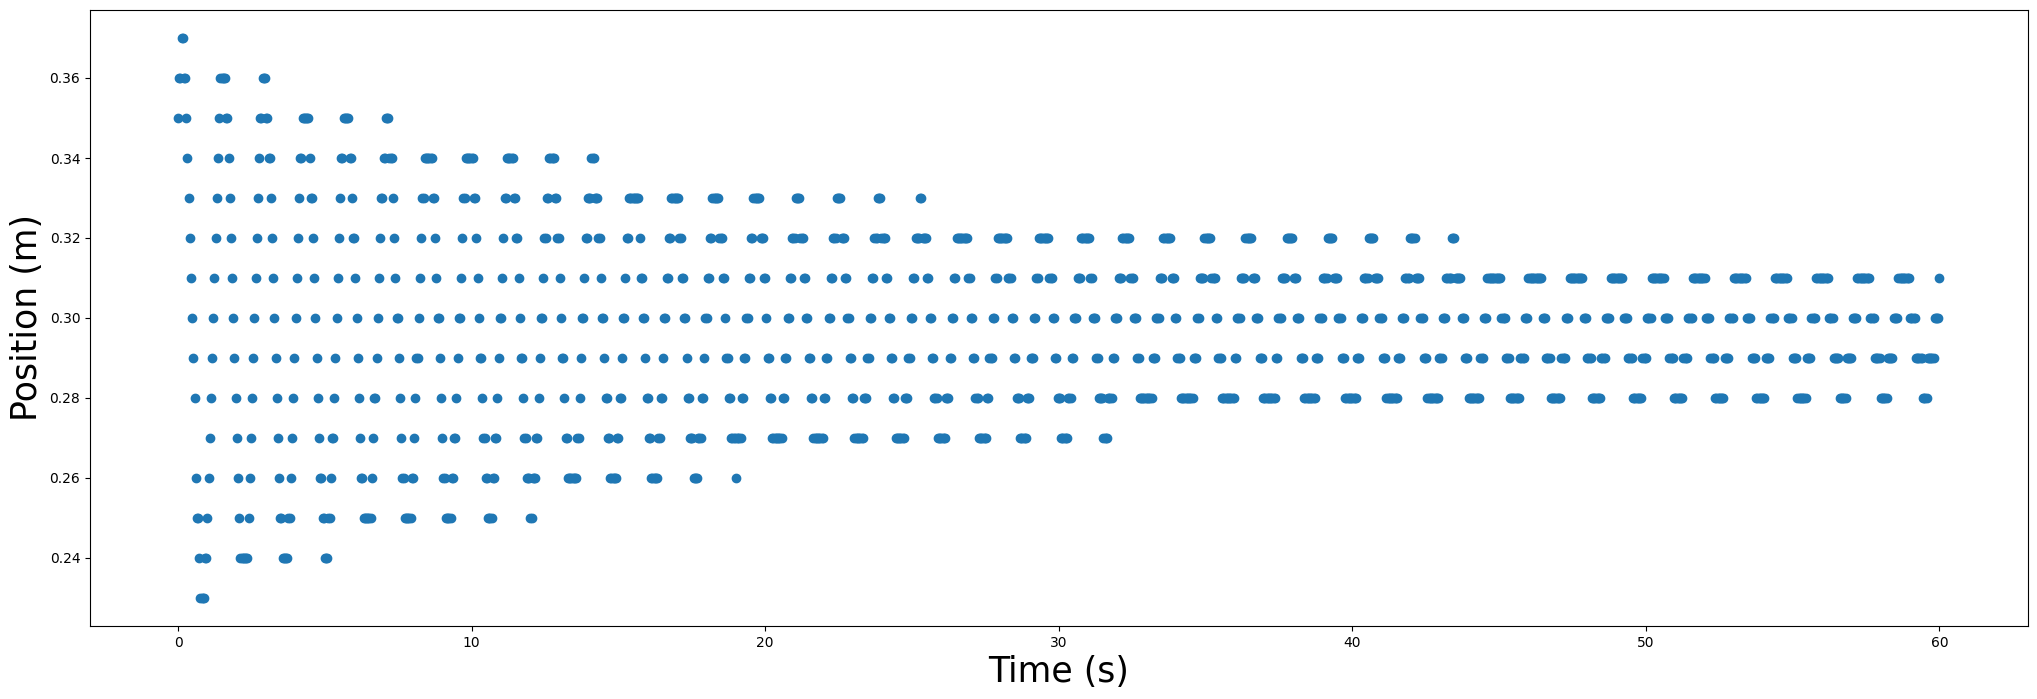

In [5]:
# optimize the range of data along the x and y axes
plt.figure(figsize=(25,8))
#plt.xlim(0,40)
#plt.ylim(-0.15,1)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Position (m)', fontsize=25)
plt.scatter(x,y)
plt.show()

## How to obtain fit values and uncertainties using Scipy curve_fit
#### Documentation at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#### More information about curve fitting at https://python4mpia.github.io/fitting_data/least-squares-fitting.html
#### First define a damped sine function
### $$A e^{-Bt} \sin(Wt+P) + C$$
Parameters are: amplitude (A), damping (B), frequency (W), phase (P) and offset (C)

In [6]:
def my_sin(x, amplitude, damp, freq, phase, offset):
    return amplitude * np.exp(-damp * x) * np.sin(x * freq + phase) + offset


#### Provide initial guess for each of the parameters and execute curve fit

In [7]:
guess_amplitude = np.max(y)-np.mean(y)
guess_damp = 0.01
guess_freq = 5
guess_phase = -3
guess_offset = np.mean(y)

p0_guess=[guess_amplitude, guess_damp, guess_freq, guess_phase, guess_offset]
print('Initial parameter values:', p0_guess)

Initial parameter values: [0.07287808127914724, 0.01, 5, -3, 0.29712191872085275]


Position measurement error; Pasco motion sensor has resolution of 1 mm

In [8]:
dy = np.full(len(x),0.001)

Perform fit from first to last specified data point. Note that data is collected at 20 Hz, i.e. a new position measurement is made every 50 ms

In [9]:
first = 0 # start at 0 s
last = first+600 # end at 60 s
fit = curve_fit(my_sin, x[first:last], y[first:last], sigma=dy[first:last], p0=p0_guess, absolute_sigma=True)

Extract fit results: parameters and covariance matrix. Compute the chi-squared.

In [10]:
print('Fit parameters:', *fit[0])
param = fit[0]
covMatrix = fit[1]
corrMatrix = np.corrcoef(covMatrix)

y_fit = my_sin(x, *fit[0])
chisq = ((y[first:last]-y_fit[first:last])/dy[first:last])**2
print('Chi-squared:',chisq.sum(), ' Number of degrees of freedom:',(last-first-5))
print('Reduced chi-squared:',chisq.sum()/(last-first-5))

Fit parameters: -0.06651830539814138 0.037054428759196435 4.495654883432708 -2.2016831887043913 0.2971841522392078
Chi-squared: 5193.6207829004  Number of degrees of freedom: 595
Reduced chi-squared: 8.728774425042689


### Plot the fit results
#### Documentation for pyplot at https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html

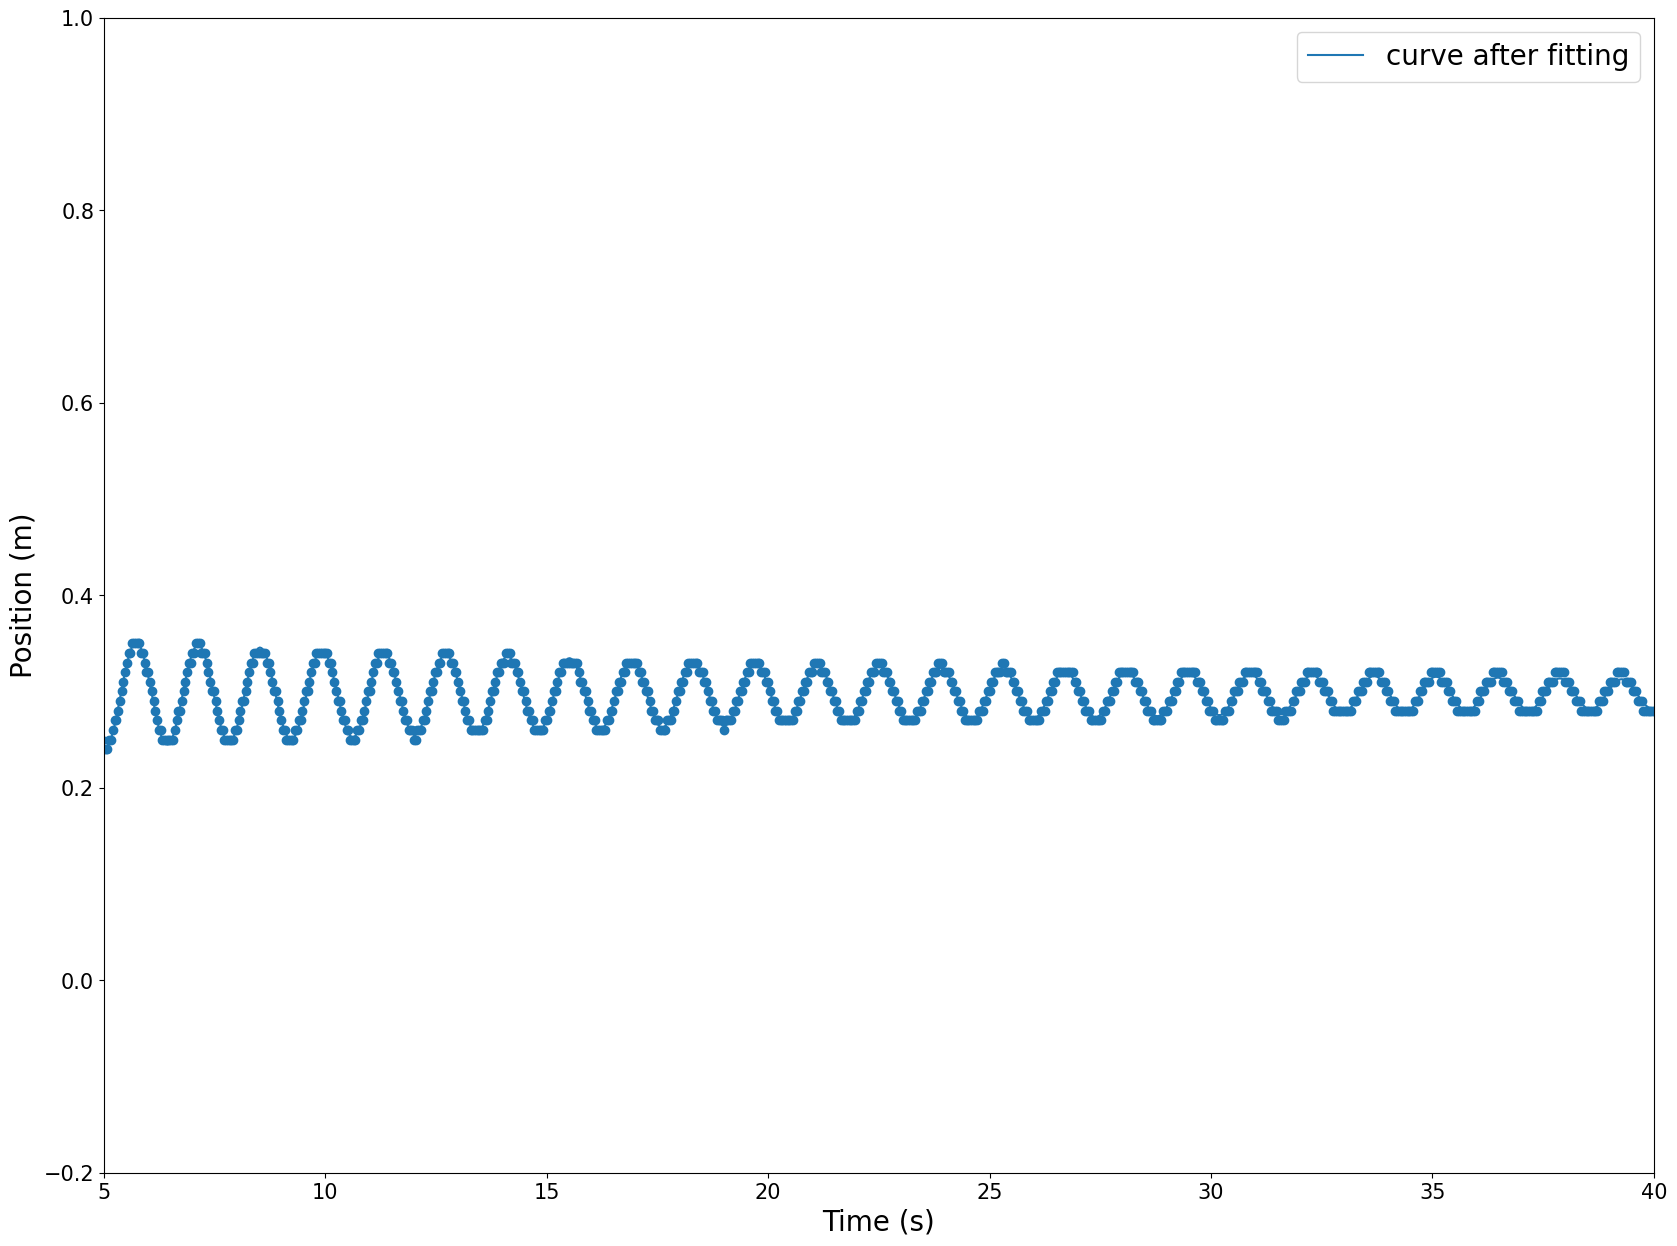

In [11]:
plt.figure(figsize=(20, 15))
ax = plt.subplot() # Defines ax variable
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

# Set boundaries for the 2-D scatter plot
xstart = 5
xstop  = 40
plt.xlim(xstart, xstop)
plt.ylim(-0.2,1)

# Plot the data
plt.scatter(x,y)

# Plot the fit results
plt.plot(x, y_fit, label='curve after fitting')
plt.legend(fontsize=20)

# Add title and axis labels
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Position (m)', fontsize=20)

plt.show()

Print the results for each of the fit parameters with the corresponding uncertainties obtained from the fit.

In [12]:
print('The amplitude (A) is           ' + "{:.4}".format(param[0]) + " +/- " + "{:.2}".format(np.sqrt(covMatrix[0,0])))
print('The damping coefficient (B) is ' + "{:.5}".format(param[1]) + " +/- " + "{:.2}".format(np.sqrt(covMatrix[1,1])))
print('The frequency (W) is           ' + "{:.5}".format(param[2]) + " +/- " + "{:.2}".format(np.sqrt(covMatrix[2,2])))
print('The phase (P) is               ' + "{:.2}".format(param[3]) + " +/- " + "{:.2}".format(np.sqrt(covMatrix[3,3])))
print('The offset (C) is              ' + "{:.2}".format(param[4]) + " +/- " + "{:.2}".format(np.sqrt(covMatrix[4,4])))


The amplitude (A) is           -0.06652 +/- 0.00014
The damping coefficient (B) is 0.037054 +/- 0.0002
The frequency (W) is           4.4957 +/- 0.0002
The phase (P) is               -2.2 +/- 0.0022
The offset (C) is              0.3 +/- 4.1e-05


In [ ]:
def calculate_b_k(m, omega, sigma_omega, a, sigma_a):
    omega0 = np.sqrt(omega**2 + a**2)
    k = m*(omega**2 + a**2)
    sigma_k = 2*m*np.sqrt((omega*sigma_omega)**2 + (a*sigma_a)**2)

    b = 2*m*a
    sigma_b = 2*m*sigma_a

    print(f"omega0 = {omega0:.3f} rad/s")
    print(f"k = {k:.3f} N/m ± {sigma_k:.3f} N/m")
    print(f"b = {b:.4f} kg/s ± {sigma_b:.4f} kg/s")


: 